# Working with Market Depth and Trades

## Display 3-depth

In [1]:
from numba import njit

@njit
def print_3depth(hbt):
    while hbt.elapse(60_000_000_000) == 0:
        print('current_timestamp:', hbt.current_timestamp)

        # Gets the market depth for the first asset, in the same order as when you created the backtest.
        depth = hbt.depth(0)

        # a key of bid_depth or ask_depth is price in ticks.
        # (integer) price_tick = rice / tick_size
        i = 0
        for price_tick in range(depth.best_ask_tick, depth.best_ask_tick + 100):
            qty = depth.ask_qty_at_tick(price_tick)
            if qty > 0:
                print(
                    'ask: ',
                    qty,
                    '@',
                    np.round(price_tick * depth.tick_size, 1)
                )
                
                i += 1
                if i == 3:
                    break
        i = 0
        for price_tick in range(depth.best_bid_tick, max(depth.best_bid_tick - 100, 0), -1):
            qty = depth.bid_qty_at_tick(price_tick)
            if qty > 0:
                print(
                    'bid: ',
                    qty,
                    '@',
                    np.round(price_tick * depth.tick_size, 1)
                )
            
                i += 1
                if i == 3:
                    break
    return True

In [2]:
import numpy as np

btcusdt_20240809 = np.load('usdm/btcusdt_20240809.npz')['data']
btcusdt_20240808_eod = np.load('usdm/btcusdt_20240808_eod.npz')['data']

In [3]:
from hftbacktest import BacktestAsset, HashMapMarketDepthBacktest

asset = (
    BacktestAsset()
        .data(btcusdt_20240809)
        .initial_snapshot(btcusdt_20240808_eod)
        .linear_asset(1.0) 
        .constant_latency(10_000_000, 10_000_000)
        .risk_adverse_queue_model() 
        .no_partial_fill_exchange()
        .trading_value_fee_model(0.0002, 0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
)

hbt = HashMapMarketDepthBacktest([asset])

print_3depth(hbt)

_ = hbt.close()

current_timestamp: 1723161661500000000
ask:  1.759 @ 61594.2
ask:  0.006 @ 61594.4
ask:  0.114 @ 61595.2
bid:  3.526 @ 61594.1
bid:  0.016 @ 61594.0
bid:  0.002 @ 61593.9
current_timestamp: 1723161721500000000
ask:  2.575 @ 61576.6
ask:  0.004 @ 61576.7
ask:  0.455 @ 61577.0
bid:  2.558 @ 61576.5
bid:  0.002 @ 61576.0
bid:  0.515 @ 61575.5
current_timestamp: 1723161781500000000
ask:  0.131 @ 61629.7
ask:  0.005 @ 61630.1
ask:  0.005 @ 61630.5
bid:  5.742 @ 61629.6
bid:  0.247 @ 61629.4
bid:  0.034 @ 61629.3
current_timestamp: 1723161841500000000
ask:  0.202 @ 61621.6
ask:  0.002 @ 61622.5
ask:  0.003 @ 61622.6
bid:  3.488 @ 61621.5
bid:  0.86 @ 61620.0
bid:  0.248 @ 61619.6
current_timestamp: 1723161901500000000
ask:  1.397 @ 61584.0
ask:  0.832 @ 61585.1
ask:  0.132 @ 61586.0
bid:  3.307 @ 61583.9
bid:  0.01 @ 61583.8
bid:  0.002 @ 61582.0


## Efficient Market Depth Access

`ROIVectorMarketDepth` provides more efficient market depth access through a vector that holds a limited price range of interest. The backtester using this feature can be created by `ROIVectorMarketDepthBacktest`.

In [4]:
from numba import njit

@njit
def print_3depth_fast(hbt):
    roi_lb_tick = int(round(30000 / 0.1))
    roi_ub_tick = int(round(90000 / 0.1))
    
    while hbt.elapse(60_000_000_000) == 0:
        print('current_timestamp:', hbt.current_timestamp)

        # Gets the market depth for the first asset, in the same order as when you created the backtest.
        depth = hbt.depth(0)

        # a key of bid_depth or ask_depth is price in ticks.
        # (integer) price_tick = price / tick_size
        i = 0
        # for price_tick in range(depth.best_ask_tick, depth.best_ask_tick + 100):
        #     # depth.ask_depth returns the ask depth array, whose length is (roi_ub_tick + 1 - roi_lb_tick),
        #     # containing the quantities ranging from roi_lb_tick to roi_ub_tick.
        #     # Checks that the price_tick is in that range and adjust the index by subtracting roi_lb_tick.
        #     if price_tick < roi_lb_tick or price_tick > roi_ub_tick:
        #         continue
        #     t = price_tick - roi_lb_tick
        #     qty = depth.ask_depth[t]
        #     if qty > 0:
        #         print(
        #             'ask: ',
        #             qty,
        #             '@',
        #             np.round(price_tick * depth.tick_size, 1)
        #         )
                
        #         i += 1
        #         if i == 3:
        #             break
        # i = 0
        # for price_tick in range(depth.best_bid_tick, max(depth.best_bid_tick - 100, 0), -1):
        #     # depth.bid_depth returns the bid depth array, whose length is (roi_ub_tick + 1 - roi_lb_tick),
        #     # containing the quantities ranging from roi_lb_tick to roi_ub_tick.
        #     # Checks that the price_tick is in that range and adjust the index by subtracting roi_lb_tick.
        #     if price_tick < roi_lb_tick or price_tick > roi_ub_tick:
        #         continue
        #     t = price_tick - roi_lb_tick
        #     qty = depth.bid_depth[t]
        #     if qty > 0:
        #         print(
        #             'bid: ',
        #             qty,
        #             '@',
        #             np.round(price_tick * depth.tick_size, 1)
        #         )
            
        #         i += 1
        #         if i == 3:
        #             break
    return True

In [5]:
from hftbacktest import ROIVectorMarketDepthBacktest

asset = (
    BacktestAsset()
        .data(btcusdt_20240809)
        .initial_snapshot(btcusdt_20240808_eod)
        .linear_asset(1.0) 
        .constant_latency(10_000_000, 10_000_000)
        .risk_adverse_queue_model() 
        .no_partial_fill_exchange()
        .trading_value_fee_model(0.0002, 0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        # Sets the lower bound price for the range of interest in the market depth.
        .roi_lb(30000)
        # Sets the upper bound price for the range of interest in the market depth.
        .roi_ub(90000)
)



In [6]:
hbt = ROIVectorMarketDepthBacktest([asset])

print_3depth_fast(hbt)

#_ = hbt.close()

current_timestamp: 1723161661500000000
current_timestamp: 1723161721500000000
current_timestamp: 1723161781500000000
current_timestamp: 1723161841500000000
current_timestamp: 1723161901500000000


True

## Order Book Imbalance

In [7]:
@njit
def orderbookimbalance(hbt, out):
    roi_lb_tick = int(round(30000 / 0.1))
    roi_ub_tick = int(round(90000 / 0.1))

    while hbt.elapse(10 * 1e9) == 0:
        depth = hbt.depth(0)
        
        mid_price = (depth.best_bid + depth.best_ask) / 2.0
        
        sum_ask_qty_50bp = 0.0
        sum_ask_qty = 0.0
        for price_tick in range(depth.best_ask_tick, roi_ub_tick + 1):
            if price_tick < roi_lb_tick or price_tick > roi_ub_tick:
                continue
            t = price_tick - roi_lb_tick
            
            ask_price = price_tick * depth.tick_size
            depth_from_mid = (ask_price - mid_price) / mid_price
            if depth_from_mid > 0.01:
                break
            sum_ask_qty += depth.ask_depth[t]
            
            if depth_from_mid <= 0.005:
                sum_ask_qty_50bp = sum_ask_qty
                
                
        sum_bid_qty_50bp = 0.0
        sum_bid_qty = 0.0
        for price_tick in range(depth.best_bid_tick, roi_lb_tick - 1, -1):
            if price_tick < roi_lb_tick or price_tick > roi_ub_tick:
                continue
            t = price_tick - roi_lb_tick
            
            bid_price = price_tick * depth.tick_size
            depth_from_mid = (mid_price - bid_price) / mid_price
            if depth_from_mid > 0.01:
                break
            sum_bid_qty += depth.bid_depth[t]
            
            if depth_from_mid <= 0.005:
                sum_bid_qty_50bp = sum_bid_qty
                
        imbalance_50bp = sum_bid_qty_50bp - sum_ask_qty_50bp
        imbalance_1pct = sum_bid_qty - sum_ask_qty
        imbalance_tob = depth.bid_depth[depth.best_bid_tick - roi_lb_tick] - depth.ask_depth[depth.best_ask_tick - roi_lb_tick]
        
        out.append((hbt.current_timestamp, imbalance_tob, imbalance_50bp, imbalance_1pct))        
    return True

In [8]:
from numba.typed import List
from numba.types import Tuple, float64

hbt = ROIVectorMarketDepthBacktest([asset])

tup_ty = Tuple((float64, float64, float64, float64))
out = List.empty_list(tup_ty, allocated=100_000)

orderbookimbalance(hbt, out)

_ = hbt.close()

In [9]:
import polars as pl

df = pl.DataFrame(out).transpose()
df.columns = ['Local Timestamp', 'TOB Imbalance', '0.5% Imbalance', '1% Imbalance']
df = df.with_columns(
    pl.from_epoch('Local Timestamp', time_unit='ns')
)

df

Local Timestamp,TOB Imbalance,0.5% Imbalance,1% Imbalance
datetime[ns],f64,f64,f64
2024-08-09 00:00:11.500,2.729,-1748.101,-3908.736
2024-08-09 00:00:21.500,4.623,-1749.435,-3512.845
2024-08-09 00:00:31.500,-6.465,-1259.897,-3357.755
2024-08-09 00:00:41.500,-7.922,-1174.185,-3471.955
2024-08-09 00:00:51.500,-2.484,-1147.597,-3461.48
…,…,…,…
2024-08-09 00:04:21.500,3.828,-1186.236,-3551.78
2024-08-09 00:04:31.500,-1.35,-1332.379,-3517.854
2024-08-09 00:04:41.500,-3.754,-1166.521,-2693.672


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
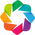

:NdOverlay   [Variable]
   :Curve   [Local Timestamp]   (value)

In [10]:
import holoviews as hv

hv.extension('bokeh')

df.plot(x='Local Timestamp')

## Display last trades between the step

In [11]:
from hftbacktest import BUY_EVENT

@njit
def print_trades(hbt):
    while hbt.elapse(60 * 1e9) == 0:
        print('-------------------------------------------------------------------------------')
        print('current_timestamp:', hbt.current_timestamp)

        # Gets the last trades occurring in the market, not the trades of our orders.
        last_trades = hbt.last_trades(0)
        
        num = 0
        for last_trade in last_trades:
            if num > 10:
                print('...')
                break
            print(
                'exch_timestamp:',
                last_trade.exch_ts,
                'buy' if (last_trade.ev & BUY_EVENT) == BUY_EVENT else 'sell',
                last_trade.qty,
                '@',
                last_trade.px
            )
            num += 1

        # To prevent accumulating all last trades, which may cause a slowdown,
        # clear_last_trades needs to be called.
        # After this, accessing `last_trades` will cause a crash.
        hbt.clear_last_trades(0)
    return True

In [12]:
asset = (
    BacktestAsset()
        .data(btcusdt_20240809)
        .initial_snapshot(btcusdt_20240808_eod)
        .linear_asset(1.0) 
        .constant_latency(10_000_000, 10_000_000)
        .risk_adverse_queue_model() 
        .no_partial_fill_exchange()
        .trading_value_fee_model(0.0002, 0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        # To retrieve the last trades, `last_trades_capacity` should be set.
        .last_trades_capacity(1000)
        .roi_lb(30000)
        .roi_ub(90000)
)

hbt = ROIVectorMarketDepthBacktest([asset])

print_trades(hbt)

_ = hbt.close()

-------------------------------------------------------------------------------
current_timestamp: 1723161661500000000
exch_timestamp: 1723161602372000000 buy 0.489 @ 61659.8
exch_timestamp: 1723161602372000000 buy 0.198 @ 61659.8
exch_timestamp: 1723161602372000000 buy 0.006 @ 61659.8
exch_timestamp: 1723161602372000000 buy 0.002 @ 61659.8
exch_timestamp: 1723161602372000000 buy 0.003 @ 61659.8
exch_timestamp: 1723161602372000000 buy 0.011 @ 61659.8
exch_timestamp: 1723161602372000000 buy 0.238 @ 61659.8
exch_timestamp: 1723161602372000000 buy 0.007 @ 61659.8
exch_timestamp: 1723161602372000000 buy 0.005 @ 61659.8
exch_timestamp: 1723161602372000000 buy 0.003 @ 61659.8
exch_timestamp: 1723161602372000000 buy 0.002 @ 61659.8
...
-------------------------------------------------------------------------------
current_timestamp: 1723161721500000000
exch_timestamp: 1723161661697000000 sell 0.002 @ 61594.1
exch_timestamp: 1723161661724000000 sell 0.002 @ 61594.1
exch_timestamp: 172316166175

## Rolling Volume-Weighted Average Price

In [13]:
@njit
def rolling_vwap(hbt, out):
    buy_amount_bin = np.zeros(100_000, np.float64)
    buy_qty_bin = np.zeros(100_000, np.float64)
    sell_amount_bin = np.zeros(100_000, np.float64)
    sell_qty_bin = np.zeros(100_000, np.float64)
    
    idx = 0
    last_trade_price = np.nan
    
    while hbt.elapse(10 * 1e9) == 0:
        last_trades = hbt.last_trades(0)
        
        for last_trade in last_trades:
            if (last_trade.ev & BUY_EVENT) == BUY_EVENT:
                buy_amount_bin[idx] += last_trade.px * last_trade.qty
                buy_qty_bin[idx] += last_trade.qty
            else:
                sell_amount_bin[idx] += last_trade.px * last_trade.qty
                sell_qty_bin[idx] += last_trade.qty
                
        hbt.clear_last_trades(0)
        idx += 1

        if idx >= 1:
            vwap10sec = np.divide(
                buy_amount_bin[idx - 1] + sell_amount_bin[idx - 1], 
                buy_qty_bin[idx - 1] + sell_qty_bin[idx - 1]
            )
        else:
            vwap10sec = np.nan
        
        if idx >= 6:
            vwap1m = np.divide(
                np.sum(buy_amount_bin[idx - 6:idx]) + np.sum(sell_amount_bin[idx - 6:idx]), 
                np.sum(buy_qty_bin[idx - 6:idx]) + np.sum(sell_qty_bin[idx - 6:idx])
            )
            buy_vwap1m = np.divide(np.sum(buy_amount_bin[idx - 6:idx]), np.sum(buy_qty_bin[idx - 6:idx]))
            sell_vwap1m = np.divide(np.sum(sell_amount_bin[idx - 6:idx]), np.sum(sell_qty_bin[idx - 6:idx]))
        else:
            vwap1m = np.nan
            buy_vwap1m = np.nan
            sell_vwap1m = np.nan
        
        out.append((hbt.current_timestamp, vwap10sec, vwap1m, buy_vwap1m, sell_vwap1m))
    return True

In [14]:
hbt = ROIVectorMarketDepthBacktest([asset])

tup_ty = Tuple((float64, float64, float64, float64, float64))
out = List.empty_list(tup_ty, allocated=100_000)

rolling_vwap(hbt, out)

_ = hbt.close()

In [15]:
df = pl.DataFrame(out).transpose()
df.columns = ['Local Timestamp', '10-sec VWAP', '1-min VWAP', '1-min Buy VWAP', '1-min Sell VWAP']
df = df.with_columns(
    pl.from_epoch('Local Timestamp', time_unit='ns')
)

df

Local Timestamp,10-sec VWAP,1-min VWAP,1-min Buy VWAP,1-min Sell VWAP
datetime[ns],f64,f64,f64,f64
2024-08-09 00:00:11.500,61687.182976,NaN,NaN,NaN
2024-08-09 00:00:21.500,61709.337576,NaN,NaN,NaN
2024-08-09 00:00:31.500,61697.538054,NaN,NaN,NaN
2024-08-09 00:00:41.500,61663.958879,NaN,NaN,NaN
2024-08-09 00:00:51.500,61637.340621,NaN,NaN,NaN
…,…,…,…,…
2024-08-09 00:04:21.500,61643.009847,61624.459011,61626.495542,61622.549429
2024-08-09 00:04:31.500,61670.795685,61635.877251,61638.362314,61632.48854
2024-08-09 00:04:41.500,61643.108582,61641.846489,61648.672337,61636.032054


In [16]:
df.plot(x='Local Timestamp')

:NdOverlay   [Variable]
   :Curve   [Local Timestamp]   (value)